# Suggesting how a project can be improved

**The purpose of this notebook is determine and validate a method to compare the most predictive meta features of a project with top performing projects with the goal of providing areas for improvement.**

In [1]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import feature_engineering
from scipy import sparse
from sklearn.externals import joblib

# Set figure display options
%matplotlib inline
sns.set(context='notebook', style='darkgrid')
sns.set(font_scale=1.3)

Let's begin loading the pre-trained scaler, vectorizer and classifier.

In [2]:
# Load serialized scaler and vectorizer
scaler = joblib.load('data/trained_models/trained_scaler.pkl')
vectorizer = joblib.load('data/trained_models/vectorizer_250.pkl')

# Load model pretrained on meta features and n-grams
clf = joblib.load('data/trained_models/trained_classifier.pkl')

We need to define which meta features we want to provide recommendations for. These will be selected as the top positive predictors of success.

In [3]:
# List of meta features to use in models
features = ['num_sents', 'num_words', 'num_all_caps', 'percent_all_caps',
            'num_exclms', 'percent_exclms', 'num_apple_words',
            'percent_apple_words', 'avg_words_per_sent', 'num_paragraphs',
            'avg_sents_per_paragraph', 'avg_words_per_paragraph',
            'num_images', 'num_videos', 'num_youtubes', 'num_gifs',
            'num_hyperlinks', 'num_bolded', 'percent_bolded']

# List of meta features that were most predictive of funded projects
predictive_features = ['num_hyperlinks', 'num_images', 'num_apple_words',
                       'num_exclms', 'percent_bolded', 'num_words']

Let's load up the training set from PostgreSQL so we can determine the top performing projects.

In [4]:
# Set database credentials
db_name1 = 'section1_db'
usernm = 'redwan'
host = 'localhost'
port = '5432'
pwd = 'pentium'

# Prepare a connection to database for section 1
con1 = psycopg2.connect(
    database=db_name1, 
    host='localhost',
    user=usernm,
    password=pwd
)

# Query all data from both campaign sections
sql_query1 = 'SELECT * FROM section1_db;'
section1_df_full = pd.read_sql_query(sql_query1, con1)

To define a quantitative measure of success, we'll use the percent above or below the project goal. Next, we'll select the projects in the top 5% and clean the dataset.

In [5]:
# Define a target variable for defining top performing projects
section1_df_full['percent_funded'] = section1_df_full['pledged'] / \
    section1_df_full['goal']

# Select projects that are within the top 1%
quantile_limit = section1_df_full['percent_funded'].quantile(q=0.95)
top_projects = section1_df_full[section1_df_full['percent_funded'] >= \
                                quantile_limit]

# Select meta features for top projects
X = top_projects[features]

# Remove all rows with no data
X_cleaned = X[~X.isnull().all(axis=1)]

# Fill remaining missing values with zero
X_cleaned = X_cleaned.fillna(0)

To aggregate the top performing projects, we can use the mean of the values of each meta feature. Next, we'll standardize the averaged meta features using the scaler used in the training set.

In [6]:
# Compute the average meta feature of the top projects
avg_top_projects = X_cleaned.mean()

# Compute the feature vector for the average top project
top_project_std = pd.Series(
    scaler.transform([avg_top_projects]).ravel(),
    index=features)

Let's store the standardized meta features of the averaged top projects for later use.

In [7]:
# Save the top project vector
#joblib.dump(top_project_std, 'top_5_percent_vector.pkl')

# Alternatively load the feature vector for the average top project
#top_project_std = joblib.load('data/top_5_percent_vector.pkl')

Let's select a project hyperlink to test.

In [8]:
# Select a hyperlink
#hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble-time-awesome-smartwatch-no-compromises'
#hyperlink = 'https://www.kickstarter.com/projects/1385294316/help-me-start-my-cottage-industry-bakesalecom?ref=category_newest'
hyperlink = 'https://www.kickstarter.com/projects/getpebble/pebble-2-time-2-and-core-an-entirely-new-3g-ultra'

We need to scape the project page, collect the campaign, and extract meta features. Next, we'll use the scaler used in the training set to standardize the meta features.

In [9]:
# Compute the meta features and preprocess the campaign section
meta_features, processed_section = feature_engineering.process_project(
    hyperlink
)

# Standardize the feature vector
feature_vector_std = pd.Series(
    scaler.transform([meta_features]).ravel(),
    index=features
)

Using the classifier we can compute the feature importance.

In [10]:
# Compute meta feature ranks
feature_ranks = pd.Series(
    clf.coef_.T.ravel()[:len(features)],
    index=features
)

To determine how much each project focused on each feature, let's define the "strength" of each of the feature we're interested in by multiplying the parameter weight of the feature with the value of that feature. High values of this product are indicative of project's that emphasized this feature. Finally, we'll compare these products to those of the top performing projects as a standard.

In [11]:
# Compute the strength of the meta features of the user's project
user_project_strength = np.multiply(
    feature_vector_std[predictive_features],
    feature_ranks[predictive_features]
)

# Compute the strength of the meta features of the average top project
top_project_strength = np.multiply(
    top_project_std[predictive_features],
    feature_ranks[predictive_features]
)

To visualize the two strength metrics easily in Seaborn, we need to transform the dataset into "tidy" format.

In [12]:
# Combine the strength metrics into one DataFrame
messy = pd.DataFrame(
    [user_project_strength, top_project_strength], 
    index=['My project', 'Top 5% of projects']
).T.reset_index()

# Transform the combined data into tidy format
tidy = pd.melt(
    messy,
    id_vars='index',
    value_vars=['My project', 'Top 5% of projects'],
    var_name=' '
)

Finally, let's draw a grouped plot of the strengths. This graph serves to provide the user a way to 

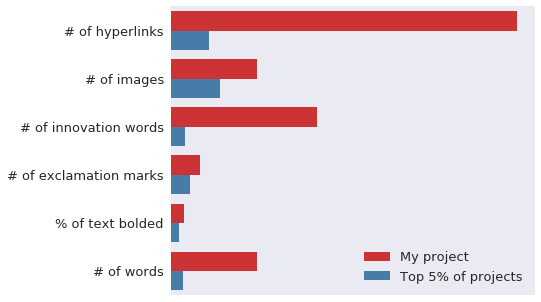

In [17]:
# Draw a grouped bar plot
fig = sns.factorplot(
    data=tidy,
    y='index',
    x='value',
    hue=' ',
    kind='bar',
    size=5,
    aspect=1.5,
    palette='Set1',
    legend_out=False
).set(xlabel='', ylabel='', xticks=[]);

# Re-label the y-axis
labels = ['# of hyperlinks', '# of images', '# of innovation words',
          '# of exclamation marks', '% of text bolded', '# of words']
plt.yticks(np.arange(6), labels)
fig.ax.legend(loc='lower right');